In [64]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, precision_score
from hyperopt import space_eval
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

import statsmodels.api as sm
from scipy.stats import t



### Reasons for dividing models for column and panel

- Difficulty with imputing nan values for panel
- Larger feature space
- Might want to include 'compact radiator type' as that could give indication of equivalent of 'cols' ('width' of panel radiator)


##### Data clean up

In [3]:
df = pd.read_csv('Radiators.csv')

In [4]:
df.head()

,Type,Manufacturer,Range,Compact Radiator Type,Column Style,Material,Height,Width,Sections / Elements,Cols,Manu. Part Number,Heat Output Watts (dT50),Heat Output Btu/hr (1),n coefficient Strategy,n coefficient
0,Panel,Stelrad,Compact,11.00,NaN,Steel,300,500,15.00,NaN,143650,255,870.00,Default,1.30
1,Panel,Stelrad,Compact,11.00,NaN,Steel,300,1000,30.00,NaN,143651,509,1737.00,Default,1.30
2,Panel,Stelrad,Compact,11.00,NaN,Steel,300,1500,45.00,NaN,143652,764,2608.00,Default,1.30
3,Panel,Stelrad,Compact,11.00,NaN,Steel,300,2000,60.00,NaN,143653,1018,3474.00,Default,1.30
4,Panel,Stelrad,Compact,11.00,NaN,Steel,300,2500,75.00,NaN,143654,1273,4345.00,Default,1.30


In [5]:
df_new = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133 entries, 0 to 5132
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      5133 non-null   object 
 1   Manufacturer              5133 non-null   object 
 2   Range                     5133 non-null   object 
 3   Compact Radiator Type     867 non-null    float64
 4   Column Style              106 non-null    object 
 5   Material                  5133 non-null   object 
 6   Height                    5133 non-null   int64  
 7   Width                     5133 non-null   int64  
 8   Sections / Elements       4719 non-null   float64
 9   Cols                      4242 non-null   float64
 10  Manu. Part Number         5133 non-null   object 
 11  Heat Output Watts (dT50)  5133 non-null   int64  
 12  Heat Output Btu/hr (1)    997 non-null    float64
 13  n coefficient Strategy    501 non-null    object 
 14  n coeffi

In [6]:
df = df.drop(['Range','Manufacturer','Material', 'Compact Radiator Type','Manu. Part Number','Heat Output Btu/hr (1)','n coefficient Strategy', 'n coefficient', 'Column Style'], axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133 entries, 0 to 5132
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      5133 non-null   object 
 1   Height                    5133 non-null   int64  
 2   Width                     5133 non-null   int64  
 3   Sections / Elements       4719 non-null   float64
 4   Cols                      4242 non-null   float64
 5   Heat Output Watts (dT50)  5133 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 240.7+ KB


In [8]:
df = df.loc[df.Type == 'Column']

In [9]:
df = df.drop(['Type'], axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4242 entries, 255 to 5132
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Height                    4242 non-null   int64  
 1   Width                     4242 non-null   int64  
 2   Sections / Elements       4242 non-null   float64
 3   Cols                      4242 non-null   float64
 4   Heat Output Watts (dT50)  4242 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 198.8 KB


In [11]:
df = df.rename(columns = {'Sections / Elements': 'Sections_Elements', 'Heat Output Watts (dT50)' : 'Heat'})

In [12]:
df

,Height,Width,Sections_Elements,Cols,Heat
255,300,444,9.00,3.00,288
256,300,628,13.00,3.00,416
257,300,858,18.00,3.00,576
258,300,1042,22.00,3.00,704
259,300,1272,27.00,3.00,864
...,...,...,...,...,...
5128,3000,700,14.00,6.00,7480
5129,3000,750,15.00,6.00,8015
5130,3000,800,16.00,6.00,8549
5131,3000,850,17.00,6.00,9083


##### EDA

In [13]:
import random
seed = random.randint(1000,9999)
print(seed)

7093


In [14]:
df.describe()

,Height,Width,Sections_Elements,Cols,Heat
count,4242.00,4242.00,4242.00,4242.00,4242.00
mean,1023.11,1254.78,25.11,3.93,2976.40
std,757.54,661.35,13.23,1.40,2380.47
min,155.00,200.00,4.00,2.00,51.00
25%,450.00,700.00,14.00,3.00,1134.00
50%,750.00,1200.00,24.00,4.00,2257.00
75%,1500.00,1800.00,36.00,5.00,4209.50
max,3000.00,2500.00,50.00,6.00,12635.00


##### Comments

- std of many of our features and target variable are significant


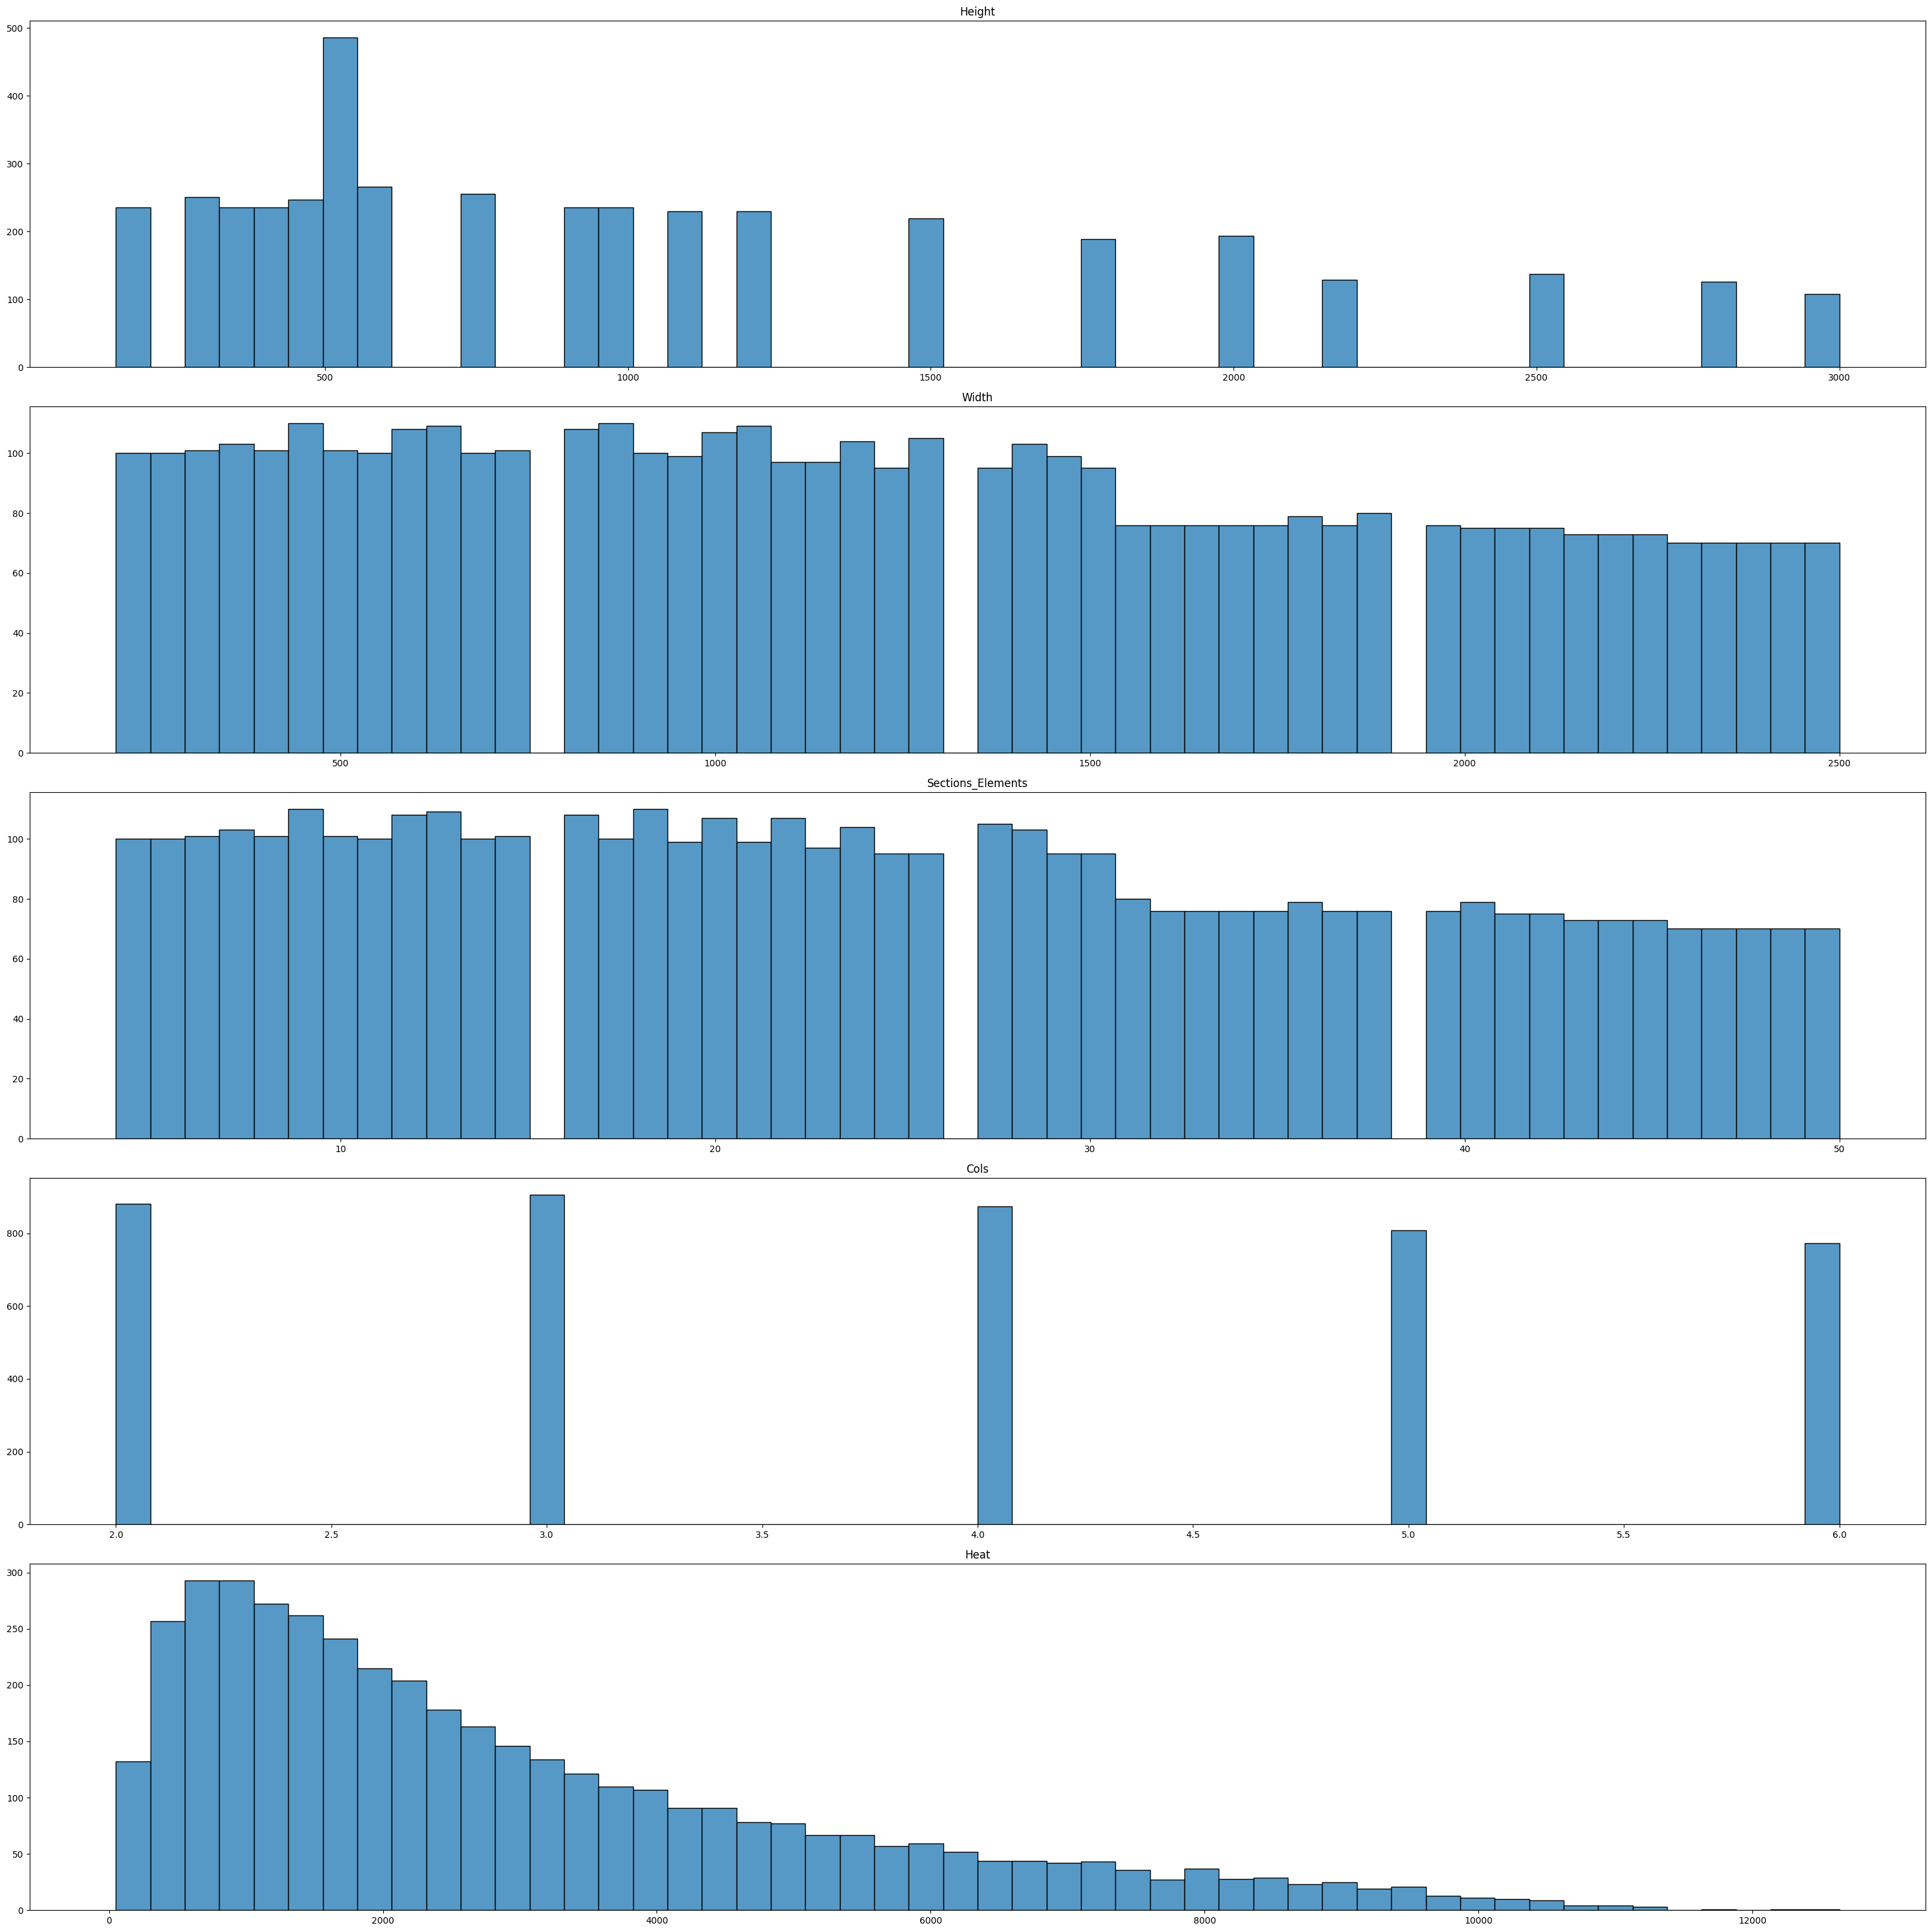

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(30,30), ncols=1, nrows=5)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Comments

- Heat strongly skewed to the left. Might have to consider applying transform here (like box cox)
- Height, Width and Sections_Elements slightly skewed to the left, but quite even generally
- Cols evenly distributed

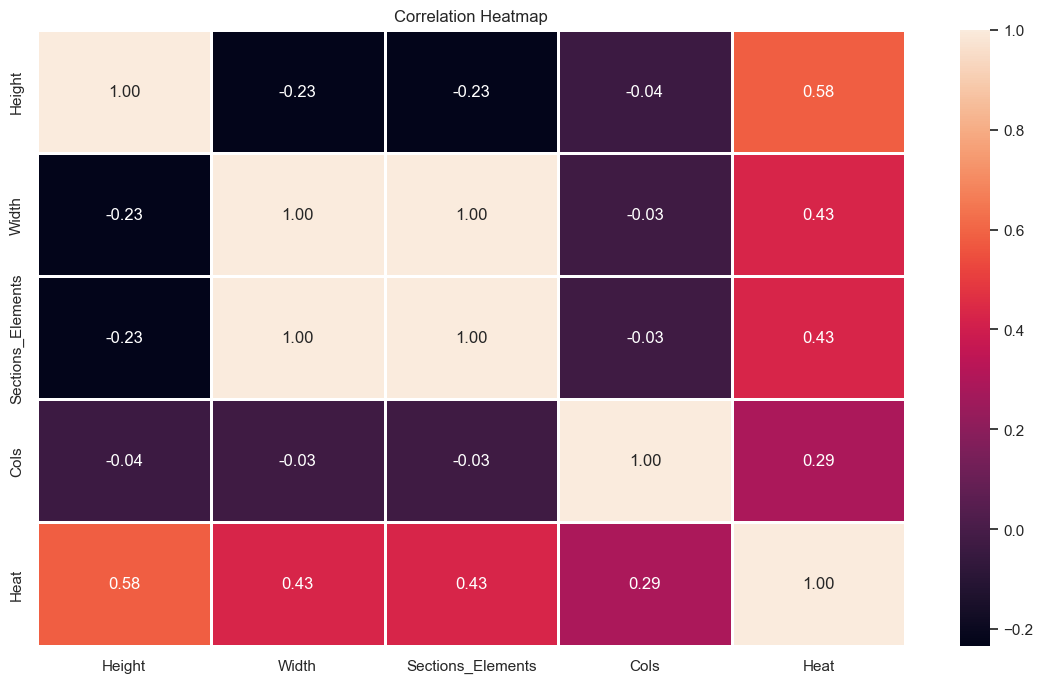

In [17]:
# Or without droping the output directly, easy to see all pairs
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

#### Comments
- Sections_elements and width strongly correlated. Will remove one of them.
- No strong correlation coefficients between any two other feature variables, which makes sense. No strong correlations between target variable and any feature variable.

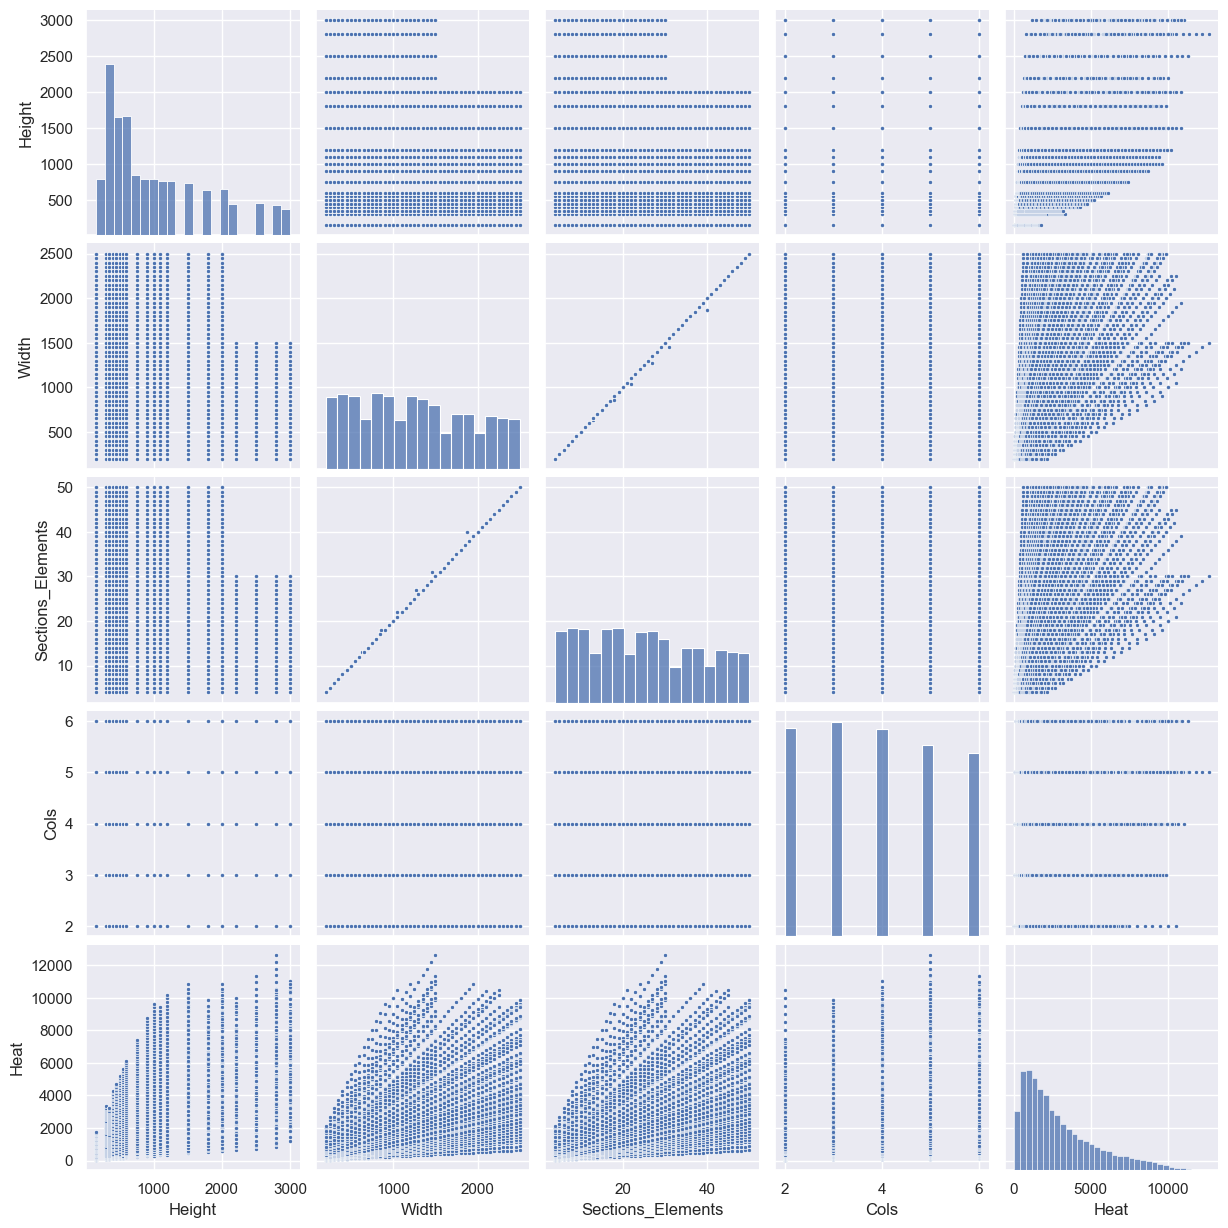

In [79]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df,  markers=".")
plt.show()

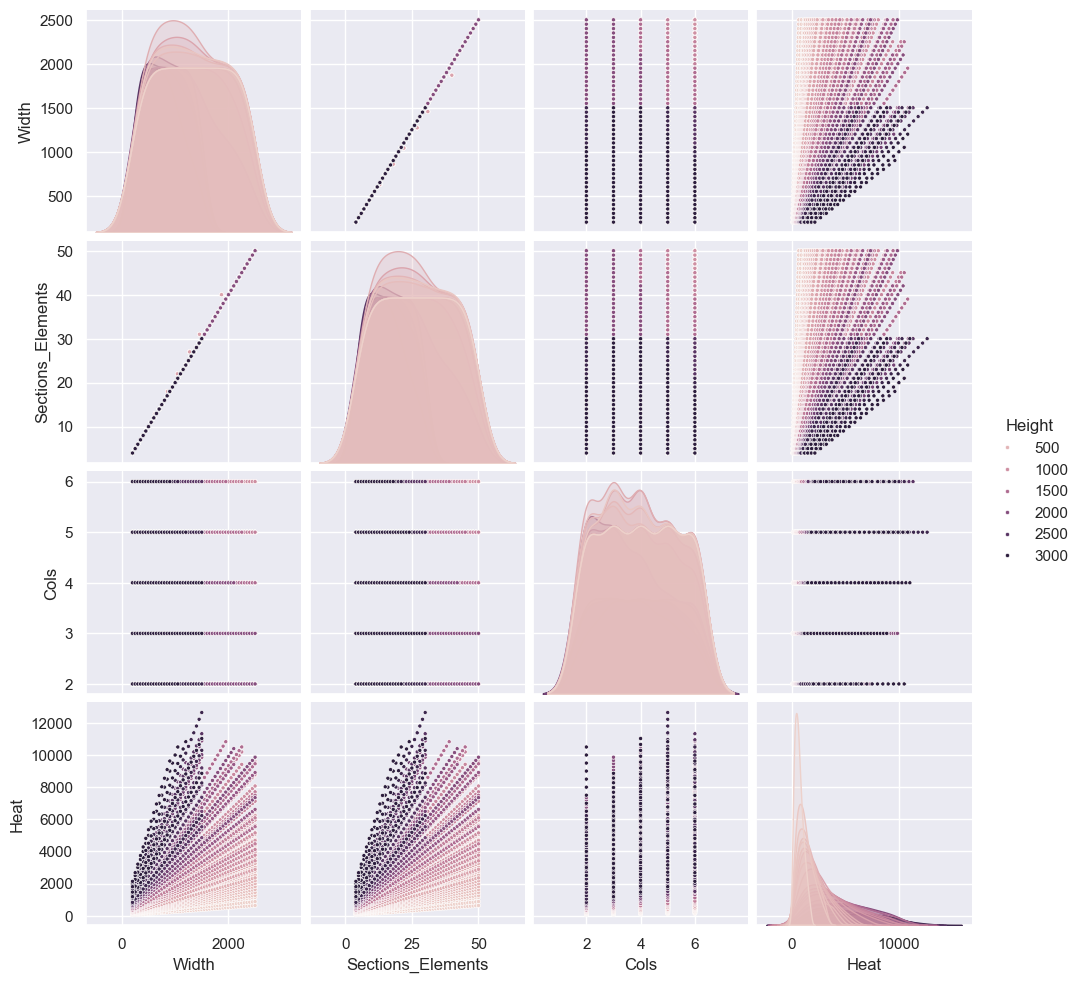

In [77]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue='Height', markers=".")
plt.show()

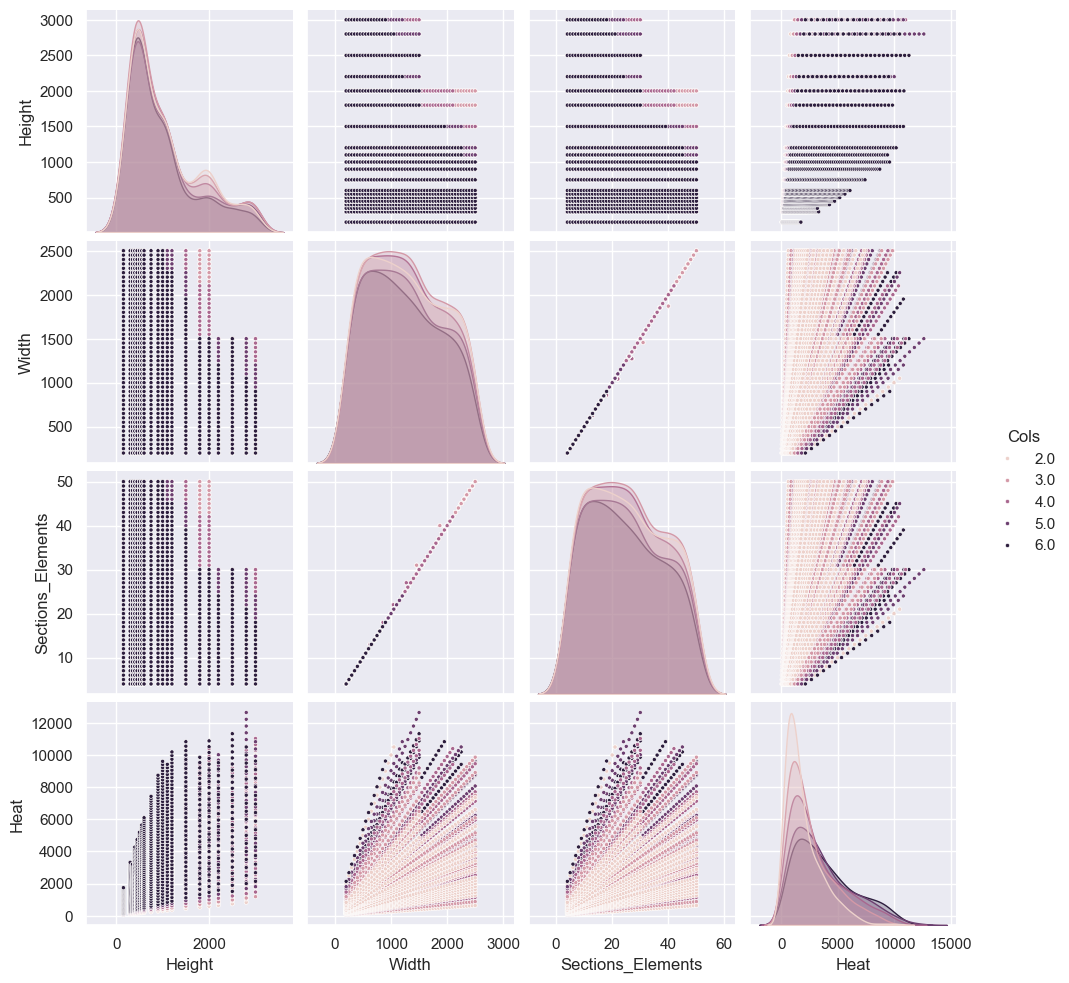

In [80]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue='Cols', markers=".")
plt.show()

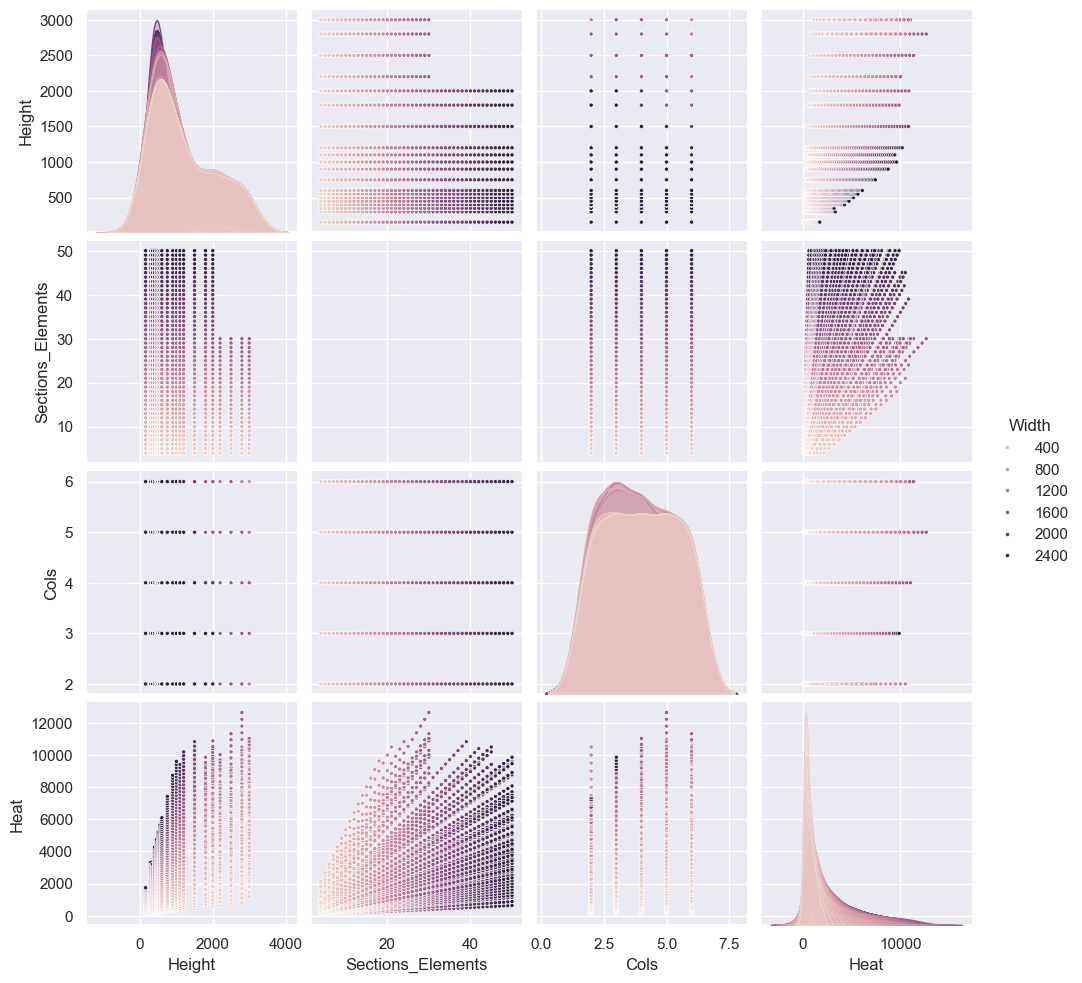

In [81]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue='Width', markers=".")
plt.show()

##### Comments

- Again, clearly strong correlation between 'Width' and 'Sections_Elements'
- Interesting 'linear' relationships between width, section_elements and heat.


In [15]:
df = df.drop(['Sections_Elements'], axis = 1)

In [16]:
X = df.drop(['Heat'], axis = 1)
features = list(X.columns)
X = X.values
y = df['Heat'].copy()
y = y.values

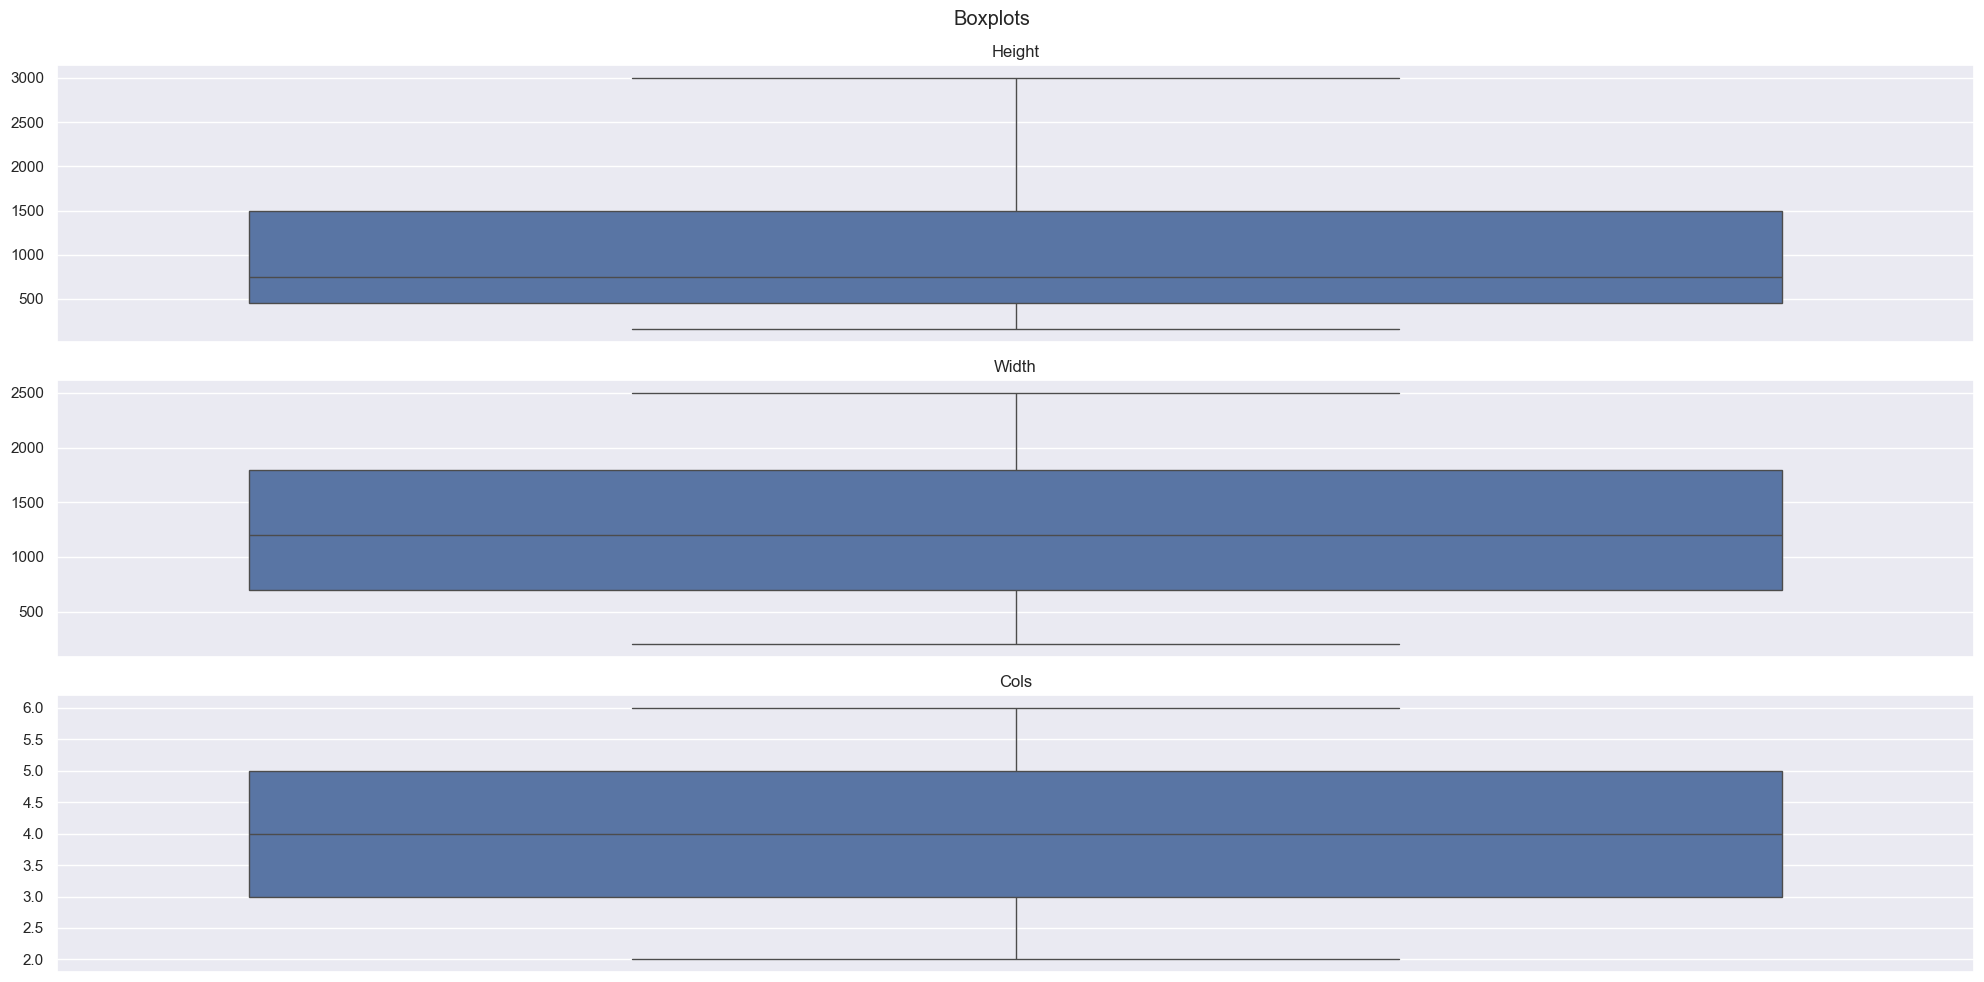

In [20]:
fig, axes = plt.subplots(figsize = (20,10), ncols = 1, nrows = 3, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = X[:,i], ax = ax) 
    ax.set_title(features[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

##### Comments

- No clear outliers in data

#### Training test data splits

In [ ]:


'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

'''

In [17]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values





### Linear Regression Model

In [18]:
def print_evaluation(y_train, y_fit, y_test, y_pred):
    '''Prints the model evaluation.
    '''
    # The mean squared error of the training set 
    print("Training Mean squared error: %.3f" % mean_squared_error(y_train, y_fit))
    # The root mean squared error of the training set 
    print("Training Root-Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_train, y_fit)))
    # The coefficient of determination of the training set 
    print("Training R squared: %.3f" % r2_score(y_train, y_fit))
    
    # The mean squared error of the test set 
    print("Test Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
    # The root mean squared error of the test set 
    print("Test Root-Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    # The coefficient of determination of the test set 
    print("Test R squared: %.3f" % r2_score(y_test, y_pred))

In [19]:
def get_coefs(m):
    '''Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    '''
    # If pipeline, use the last step as the model
    if (isinstance(m, Pipeline)):
        m = m.steps[-1][1]
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [20]:
def plot_fit(y, y_hat):
    '''Plotting an overview of the model fit including ture vs predicted scores, 
    residuals and a QQ plot
    '''
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'residual': y - y_hat}
    )
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(131)
    sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={
        'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
    sns.scatterplot(x='y', y='y_hat', data=res).set_title("True vs Predicted ")
    
    plt.subplot(132)
    sns.scatterplot(x='y_hat', y='residual', data=res).set_title("Residuals")
    plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
    
    plt.subplot(133)
    stats.probplot(res['residual'], dist="norm",plot=plt)
    plt.title('Probability Plot of Residuals')
    
    plt.tight_layout()

In [26]:
from sklearn.linear_model import LinearRegression


lin_reg = Pipeline([("min_max", MinMaxScaler()), ('model', LinearRegression(fit_intercept=True))])

y_train = y_train.reshape(-1,1)
target_scaler  = MinMaxScaler()

y_train_scaled = target_scaler.fit_transform(y_train)



In [27]:

linreg_fit = lin_reg.fit(X_train, y_train_scaled.ravel())

y_pred_scaled = linreg_fit.predict(X_test)
y_fit_scaled = linreg_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [28]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 1174488.587
Training Root-Mean squared error: 1083.738
Training R squared: 0.793
Test Mean squared error: 1179890.367
Test Root-Mean squared error: 1086.228
Test R squared: 0.790


In [30]:
print(linreg_fit['model'].coef_)
print(linreg_fit['model'].intercept_)

[0.52317473 0.40327107 0.17997077]
-0.19877138089150978


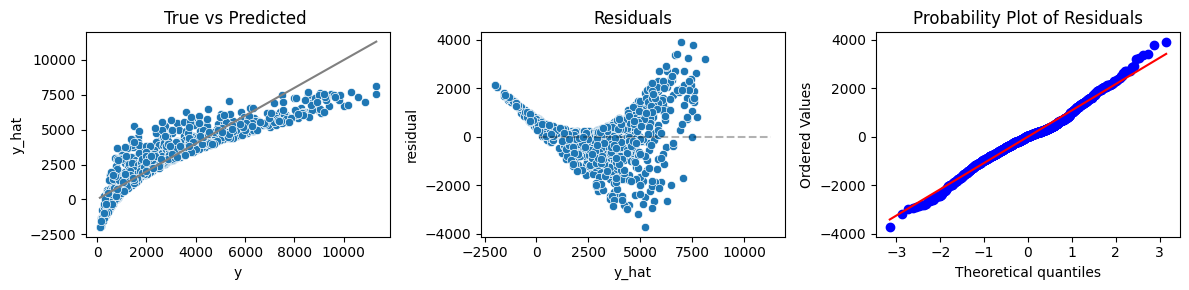

In [31]:
plot_fit(y_test, y_pred)


#### Comments

- It appears that linear model is overpredicting for low values of heat output, and underpredicting for high values of heat output.

### Polynomial Regression Model

From EDA, I've gotten hunch that including interaction term in polynomial expansion between features may suffice for this problem.

In [32]:
pf_interact = PolynomialFeatures(interaction_only=True,include_bias=False)

# Overall ML pipeline
poly_interact_pipe = Pipeline([("min_max", MinMaxScaler()), ('poly_interact', pf_interact), ('model', LinearRegression())])

poly_interact_fit = poly_interact_pipe.fit(X_train, y_train_scaled.ravel())


y_pred_scaled = poly_interact_fit.predict(X_test)
y_fit_scaled = poly_interact_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [33]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 182050.081
Training Root-Mean squared error: 426.673
Training R squared: 0.968
Test Mean squared error: 111205.913
Test Root-Mean squared error: 333.476
Test R squared: 0.980


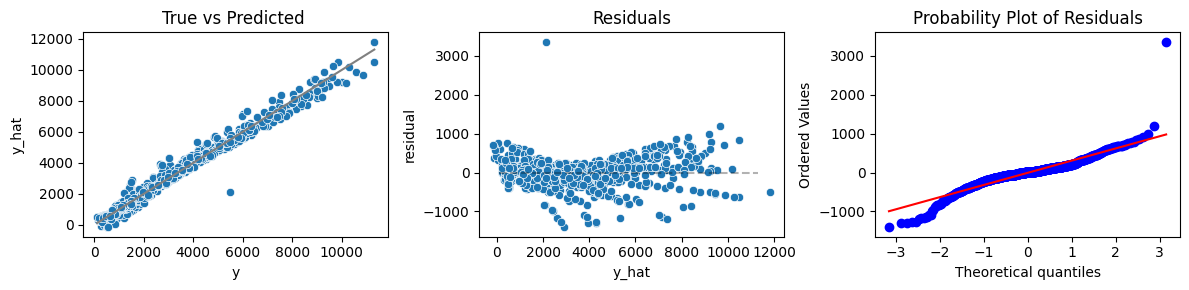

In [34]:
plot_fit(y_test, y_pred)


Much improved, but rmse still significant. R squared looking good. This means that the model captures most of the variability of 'Heat'. However, rmse still significant. Also, loooking at residual plot, we can see that model is far from perfect. It appears to overpredict for low heat values.

#### Polynomial expansion with interaction

In [53]:

pf = PolynomialFeatures()

# Overall ML pipeline
poly_interact_pipe = Pipeline([("min_max", MinMaxScaler()), 
                               ('poly', pf), 
                               ('model', LinearRegression())])




parameters = {
    'poly__degree': np.arange(1,20,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid_search = GridSearchCV(poly_interact_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

In [54]:
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)
print("coefficents", grid_search.best_estimator_['model'].coef_)

best param:  {'poly__degree': np.int64(12)}
best score:  -3542.5457652151817
coefficents [[-3.02277833e+01  7.82569764e+03  2.10493269e+02  6.76743339e+01
  -2.86057165e+05  3.19745950e+04 -5.60721688e+04  1.75135618e+04
   7.92749580e+03  6.40597072e+01  4.88405902e+06 -6.25025993e+05
   1.75103168e+06 -1.41445491e+05  9.57184736e+04  1.07957935e+05
  -3.22312237e+05 -1.47150603e+05 -1.35950038e+04 -2.82414861e+01
  -4.57380550e+07  8.18713252e+06 -2.03287385e+07  1.78174498e+06
  -3.55199410e+06 -3.32779178e+06  9.63871404e+05  1.31360569e+06
  -6.24192758e+04  2.91544935e+04  3.08690591e+06  1.25514619e+06
   2.30802640e+05 -2.25458542e+03 -2.01367569e+01  2.62733059e+08
  -5.88034875e+07  1.22438178e+08 -1.38003395e+07  3.39388239e+07
   3.82756487e+07 -6.83284996e+06  1.94087158e+06  4.99559596e+06
  -7.63528477e+05 -4.30286880e+06 -1.07979236e+07 -3.02903066e+06
  -5.47419462e+04 -2.91181905e+04 -1.74629390e+07 -6.08882681e+06
  -1.40850233e+06  3.97913331e+04  5.54674793e+03 -3.

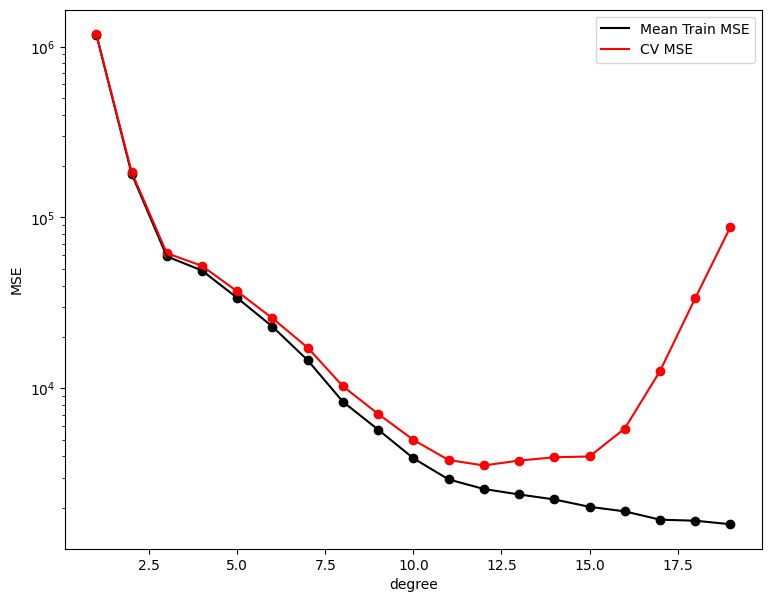

In [55]:
degree = np.arange(1,20,1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

In [56]:
pf = PolynomialFeatures(degree= 12)

# Overall ML pipeline
poly_interact_pipe_12 = Pipeline([("min_max", MinMaxScaler()), 
                               ('poly_2', pf), 
                               ('model', LinearRegression())])

poly_interact_fit = poly_interact_pipe_12.fit(X_train, y_train_scaled.ravel())


y_pred_scaled = poly_interact_fit.predict(X_test)
y_fit_scaled = poly_interact_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [57]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 2636.913
Training Root-Mean squared error: 51.351
Training R squared: 1.000
Test Mean squared error: 3139.021
Test Root-Mean squared error: 56.027
Test R squared: 0.999


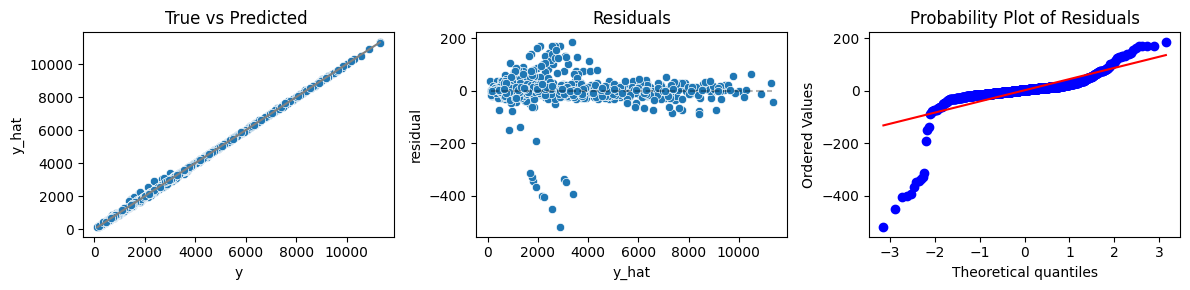

In [58]:
plot_fit(y_test, y_pred)


### Comment

- Could be interesting to see if large residual points are those in Stelrad dataset (and not Myson)

Experiment

In [46]:

pf = PolynomialFeatures()
pf_interact = PolynomialFeatures(interaction_only=True)


# Overall ML pipeline
poly_interact_pipe = Pipeline([("min_max", MinMaxScaler()), 
                               ('p_interact', pf_interact),
                               ('p_degrees', ColumnTransformer([
                                   ('poly_1', pf, [0]),
                                   ('poly_2', pf, [1]),
                                   ('poly_3', pf, [2]),
                                   ('poly_4', pf, [3])])),
                               ('model', LinearRegression())])




parameters = {
    'p_degrees__poly_1__degree': np.arange(1,15,1),
    'p_degrees__poly_2__degree': np.arange(1,15,1),
    'p_degrees__poly_3__degree': np.arange(1,15,1),
    'p_degrees__poly_4__degree': np.arange(1,15,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid_search = GridSearchCV(poly_interact_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

KeyboardInterrupt: 

In [131]:
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)


best param:  {'p_degrees__poly_1__degree': np.int64(6), 'p_degrees__poly_2__degree': np.int64(1), 'p_degrees__poly_3__degree': np.int64(9), 'p_degrees__poly_4__degree': np.int64(6)}
best score:  -405601.6266983473


#### Tests with Standard Error

In [71]:
def error_using_se(pipeline,X_train,y_train_scaled,X_new, target_scaler,alpha):
    percentile = (1 - alpha)*100

    X_train_trans = pipeline[:-1].transform(X_train)


    # Add a constant to the design matrix
    X_train_trans = sm.add_constant(X_train_trans)

    # Fit the OLS model using statsmodels.
    ols_model = sm.OLS(y_train_scaled.ravel(), X_train_trans)
    results = ols_model.fit()

    cov_beta = results.cov_params()       # Covariance matrix of the coefficients
    sigma2 = results.mse_resid            # Residual variance

    # transform X_new
    X_new_trans = pipeline[:-1].transform(X_new)


    # For each new observation, compute the variance of prediction.
    # We'll store the standard errors in a list:
    var_pred = np.dot(X_new_trans, np.dot(cov_beta, X_new_trans.T)) + sigma2
    se_pred = np.sqrt(var_pred)

    # Degrees of freedom: n - p, where n is the number of training samples
    deg_freedom = results.df_resid  
    t_val = t.ppf(1-(alpha/2), deg_freedom)  # two-tailed 95% confidence

    # Suppose you also compute the point predictions for X_new:
    y_new_pred_scaled = results.predict(X_new_trans)

    lower_bounds_scaled = y_new_pred_scaled - t_val * se_pred
    upper_bounds_scaled = y_new_pred_scaled + t_val * se_pred

    y_new_pred = target_scaler.inverse_transform(y_new_pred_scaled.reshape(-1, 1))
    lower_bounds = target_scaler.inverse_transform(lower_bounds_scaled.reshape(-1, 1))
    upper_bounds = target_scaler.inverse_transform(upper_bounds_scaled.reshape(-1, 1))
    print(f"Output = {y_new_pred}")
    print(f"Lower {percentile} percentile = {lower_bounds}")
    print(f"Upper {percentile} percentile = {upper_bounds}")

    
    return y_new_pred, lower_bounds, upper_bounds


##### Low heat output 

In [72]:
d_low = df.loc[df.Height == 300]
d_low = d_low.loc[d_low.Cols == 3]
d_low = d_low.loc[400 < d_low.Width]
d_low = d_low.loc[d_low.Width < 600]
d_low

,Height,Width,Cols,Heat
255,300,444,3.00,288
1284,300,450,3.00,319
1285,300,500,3.00,354
1286,300,550,3.00,389


In [73]:
X_low = np.array([[300.,500.,3.]])
y_low = 354

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_12,X_train,y_train_scaled,X_low, target_scaler,0.05)

Output = [[339.58822689]]
Lower 95.0 percentile = [[229.14507537]]
Upper 95.0 percentile = [[450.0313784]]


In [74]:
X_low = np.array([[300.,520.,3.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_12,X_train,y_train_scaled,X_low, target_scaler,0.05)

Output = [[354.44022241]]
Lower 95.0 percentile = [[244.17533325]]
Upper 95.0 percentile = [[464.70511156]]


In [75]:
X_low = np.array([[300.,450.,3.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_12,X_train,y_train_scaled,X_low, target_scaler,0.05)

Output = [[303.14514725]]
Lower 95.0 percentile = [[192.11403868]]
Upper 95.0 percentile = [[414.17625582]]


##### Larger heat output

In [82]:
d_middle = df.loc[df.Height == 1000]
d_middle = d_middle.loc[d_middle.Cols == 5]
d_middle = d_middle.loc[d_middle.Width < 1700]
d_middle = d_middle.loc[d_middle.Width > 1300]
d_middle

,Height,Width,Cols,Heat
3511,1000,1350,5.00,4355
3512,1000,1400,5.00,4517
3513,1000,1450,5.00,4678
3514,1000,1500,5.00,4839
3515,1000,1550,5.00,5001
3516,1000,1600,5.00,5162
3517,1000,1650,5.00,5323


In [83]:
X_middle = np.array([[1000.,1500.,5.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_12,X_train,y_train_scaled,X_middle, target_scaler,0.05)

Output = [[4822.59993663]]
Lower 95.0 percentile = [[4714.4263458]]
Upper 95.0 percentile = [[4930.77352747]]


In [84]:
X_middle = np.array([[1000.,1600.,5.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_12,X_train,y_train_scaled,X_middle, target_scaler,0.05)

Output = [[5144.59895235]]
Lower 95.0 percentile = [[5036.33755424]]
Upper 95.0 percentile = [[5252.86035047]]


##### Bootstrap

In [96]:

def bootstrap_results(pipeline, X, y, X_new, n_bootstraps, percentile, seed):
    """
    Estimate prediction intervals for X_new by bootstrapping the training data.
    
    Parameters:
    - pipeline: the scikit-learn pipeline (already defined)
    - X, y: datasets used for bootstrapping
    - X_new: new data for which to estimate prediction intervals
    - n_bootstraps: number of bootstrap samples
    - percentile: confidence level (e.g., 95 for a 95% interval)
    
    Returns:
    - lower: lower bound for each prediction
    - upper: upper bound for each prediction
    """
    all_predictions = np.zeros(n_bootstraps)
    
    for _ in range(n_bootstraps):
        # Sample indices with replacement
        X_train_boot, X_test_boot, y_train_boot, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Clone the pipeline so that each bootstrap fit is independent
        pipeline_clone = clone(pipeline)
        pipeline_clone.fit(X_train_boot, y_train_boot)
        
        # Record predictions for X_new (in the scaled space if needed)
        preds = pipeline_clone.predict(X_new)
        all_predictions[_] = preds
    
    # Convert list to array: shape (n_bootstraps, n_new_samples)
    mean = np.mean(all_predictions)
    std = np.std(all_predictions)

    # Compute lower and upper percentiles for each new sample
    lower_percentile = (100 - percentile) / 2
    upper_percentile = 100 - lower_percentile
    
    lower = np.percentile(all_predictions, lower_percentile, axis=0)
    upper = np.percentile(all_predictions, upper_percentile, axis=0)

    fig, axes = plt.subplots(1, 1, figsize=(18, 5))
    sns.histplot(all_predictions, color="royalblue", kde=True)

    print(f"Lower {percentile} percentile = {lower}")
    print(f"Upper {percentile} percentile = {upper}")
    print(f"Mean Heat Output = {mean}")
    print(f"Standard Deviation Heat Output = {std}")
    
    return all_predictions


In [89]:

d_low

,Height,Width,Cols,Heat
255,300,444,3.00,288
1284,300,450,3.00,319
1285,300,500,3.00,354
1286,300,550,3.00,389


Lower 95 percentile = 343.22217896477486
Upper 95 percentile = 343.22217896477486
Mean Heat Output = 343.2221789647748
Standard Deviation Heat Output = 5.684341886080802e-14


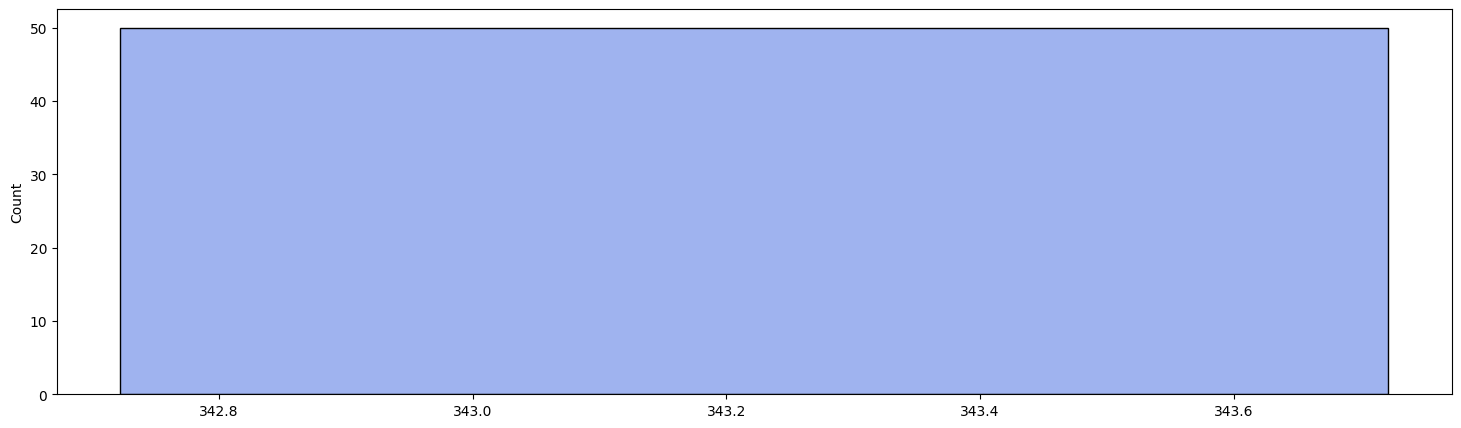

In [97]:
X_new = np.array([[300.,500.,3.]])
n_bootstraps = 1000
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

In [100]:
d_middle

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.

,Height,Width,Cols,Heat
3511,1000,1350,5.00,4355
3512,1000,1400,5.00,4517
3513,1000,1450,5.00,4678
3514,1000,1500,5.00,4839
3515,1000,1550,5.00,5001
3516,1000,1600,5.00,5162
3517,1000,1650,5.00,5323


Lower 95 percentile = 4824.576266620107
Upper 95 percentile = 4824.576266620107
Mean Heat Output = 4824.576266620107
Standard Deviation Heat Output = 0.0


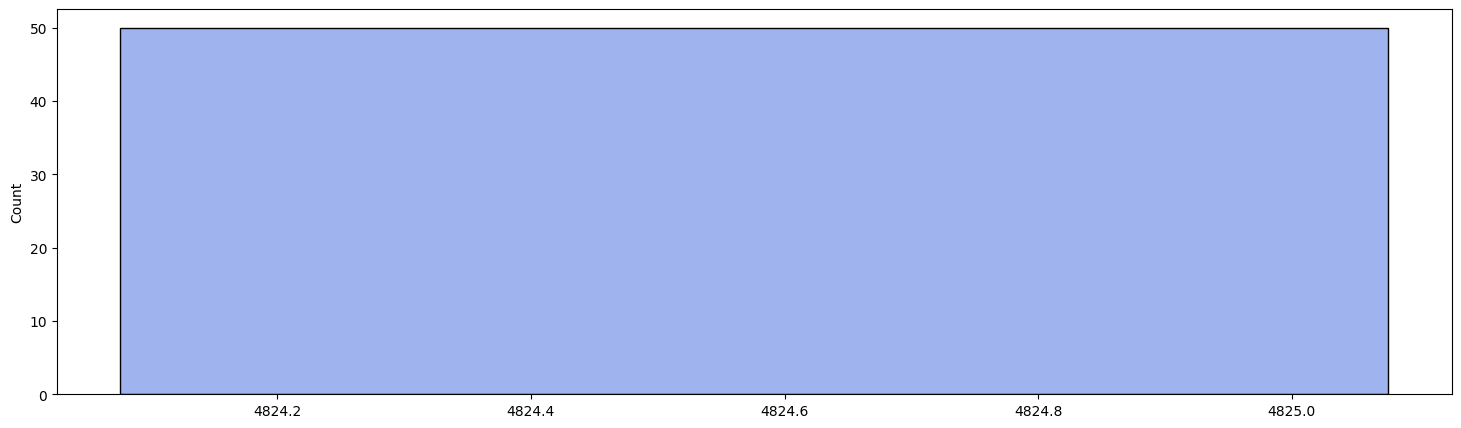

In [101]:
X_new = np.array([[1000.,1500.,5.]])
n_bootstraps = 1000
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

Lower 95 percentile = 5146.022253840908
Upper 95 percentile = 5146.022253840908
Mean Heat Output = 5146.022253840907
Standard Deviation Heat Output = 9.094947017729282e-13


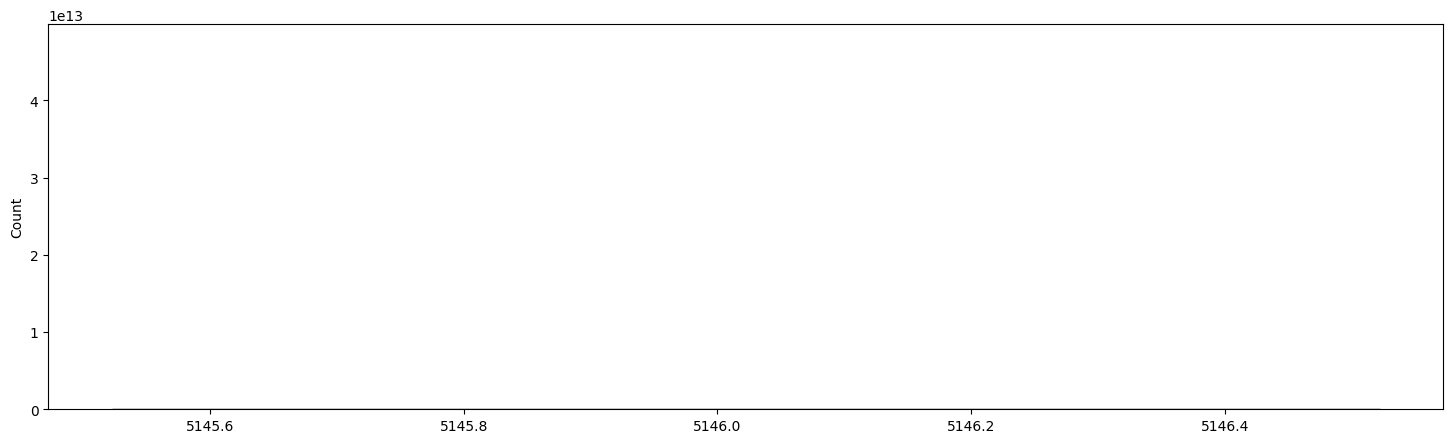

In [103]:
X_new = np.array([[1000.,1600.,5.]])
n_bootstraps = 50
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

Comments about going forward

- How do we want to quantify error?
- More data?